# Задание


    Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)
    
    Построить случайный лес, вывести важность признаков
    
    Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
    
    В качестве решения: Jupyter notebook с кодом, комментариями и графиками



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [6]:
#Находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[categorials] = data[categorials].fillna('nan')

In [7]:
categorials_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        6
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        4
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [8]:
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [9]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

In [10]:
X_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MasVnrType_None,Condition1_PosN,GarageType_2Types,BsmtQual_TA,SaleType_ConLD,GarageCond_TA,BldgType_2fmCon,Heating_Wall,BsmtFinType1_LwQ,SaleCondition_Alloca
135,136,20,80.0,10400,7,6,1970,1970,288.0,0,...,0,0,0,1,0,1,0,0,0,0
1452,1453,180,35.0,3675,5,5,2005,2005,80.0,547,...,0,0,0,0,0,1,0,0,0,0
762,763,60,72.0,8640,7,5,2009,2009,0.0,24,...,1,0,0,0,0,1,0,0,0,0
932,933,20,84.0,11670,9,5,2006,2006,302.0,0,...,0,0,0,0,0,1,0,0,0,0
435,436,60,43.0,10667,7,6,1996,1996,0.0,385,...,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,78.0,9317,6,5,2006,2006,0.0,24,...,1,0,0,0,0,1,0,0,0,0
1130,1131,50,65.0,7804,4,3,1928,1950,0.0,622,...,1,0,0,1,0,1,0,0,0,0
1294,1295,20,60.0,8172,5,7,1955,1990,0.0,167,...,1,0,0,1,0,1,0,0,0,0
860,861,50,55.0,7642,7,8,1918,1998,0.0,0,...,1,0,0,1,0,1,0,0,0,0


In [11]:
# Создаем модель RandomForest
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

RandomForestRegressor()

In [12]:
clf_rf.score(X_train, y_train)

0.9775293654838489

In [13]:
clf_rf.score(X_test, y_test)

0.8969244087814585

In [14]:
imp = pd.Series(clf_rf.feature_importances_)
imp.index = pd.Series(X_train.columns)

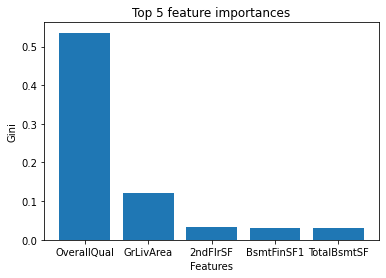

In [15]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending=False).head())
plt.show()

In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [17]:
# Создаем стэккинг и обучаем его на наших данных 

Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

In [18]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [19]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)
reg = StackingRegressor(
    estimators=estimators,
     final_estimator=final_estimator)

In [22]:
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lasso', LassoCV(random_state=42)),
                              ('knr',
                               KNeighborsRegressor(metric='euclidean',
                                                   n_neighbors=20))],
                  final_estimator=GradientBoostingRegressor(max_features=1,
                                                            min_samples_leaf=25,
                                                            n_estimators=25,
                                                            random_state=42,
                                                            subsample=0.5))

In [23]:
y_pred = reg.predict(X_test)
from sklearn.metrics import r2_score
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.82
